# Reddit Radar

This is a simple agent that: 

1. Scans a set of topics from a user's input and formats them into a structured list
2. It gather context from a specific subreddit 
3. For each topic in the list
- It scans the context from the subreddit
- It then generates a list of takes 

In [19]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "reddit-radar"

### Utility Functions

Get context from the specified subreddit

In [3]:
import os
import praw

# Reddit credentials
reddit_client_id = os.getenv('REDDIT_CLIENT_ID')
reddit_client_secret = os.getenv('REDDIT_CLIENT_SECRET')

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent='Reddit Agent Loader')

def get_recent_reddit_posts(subreddit_name,
                            filter_to_use,
                            number_of_posts,
                            number_of_comments,
                           ):

    """
    Retrieve top posts and their comments from a specified subreddit.

    Args:
    subreddit_name (str): Name of the subreddit to fetch posts from.
    filter_to_use (str): Time filter for top posts (e.g., 'day', 'week', 'month', 'year', 'all').
    number_of_posts (int): Number of top posts to retrieve.
    number_of_comments (int): Number of top comments to fetch for each post.

    Returns:
    str: A formatted string containing information about the top posts and their comments.
         Each post entry includes:
         - Post title
         - Post URL
         - Post score
         - Top comments (up to the specified number) with their scores
         Posts are separated by a line of '=' characters.

    Note:
    This function requires a properly initialized 'reddit' object with necessary permissions.
    """

    # Access the subreddit
    subreddit = reddit.subreddit(subreddit_name)
    
    # Get top posts based on the specified filter
    top_posts = subreddit.top(time_filter=filter_to_use, limit=number_of_posts)
    
    # Initialize an empty string to store the output
    reddit_expert_context = ""
    
    # Process each post
    for post in top_posts:
        reddit_expert_context += f"Title: {post.title}\n"
        reddit_expert_context += f"Source Data URL: {post.url}\n"
        reddit_expert_context += f"Reddit Post URL: {post.shortlink}\n"
        reddit_expert_context += f"Score: {post.score}\n"
        
        post.comments.replace_more(limit=0)  # Flatten the comment tree
        
        # Get the specified number of top comments
        for i, comment in enumerate(post.comments[:number_of_comments]):
            reddit_expert_context += f"Top Comment {i+1}: {comment.body}\n"
            reddit_expert_context += f"Comment Score: {comment.score}\n\n"
        
        reddit_expert_context += "="*50 + "\n\n"

    return reddit_expert_context

In [21]:
from langchain_anthropic import ChatAnthropic 
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0) 

In [40]:
import operator
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, List, Annotated

class Take(BaseModel):
    title: str = Field(
        description="Punchy summary title for the take",
    )
    take: str = Field(
        description="Fun, punchy observation about the newsworthy topic",
    )
    source_url: str = Field(
        description="Source data URL for information in the take (if applicable)",
    )
    reddit_url: str = Field(
        description="Reddit post URL for the post",
    )
    reasoning: str = Field(
        description="Provide your reasoning for the take, which confirms that the take is relevant to the newsworthy topic",
    )

class Takes(BaseModel):
    takes: List[Take] = Field(
        description="A list of takes, each containing a title and a take observation."
    )

class TakeGeneratorOutputState(TypedDict):
    takes: List[Take]

class TakeGeneratorState(TypedDict):
    user: str
    topic: str
    context: str
    subreddit_name: str
    takes: List[Take]

class OverallState(TypedDict):
    user: str
    context: str
    subreddit_name: str
    user_provided_topics:str
    takes: Annotated[List[Take], operator.add]

class Topics(BaseModel):
    user_topics: list = Field(None, description="List of user-supplied topics of interest.")

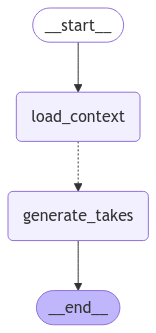

In [41]:
from langchain_core.messages import SystemMessage, HumanMessage

from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

from IPython.display import Image, display

take_instructions="""Your job is to generate fun, punchy takes on a topic of interest for this subreddit: {subreddit_name}

For each news item, systematically cross-reference it against the topic of interest, topic: {topic}

IMPORTANT: Only generate takes for news that is DIRECTLY related to the topic of interest.

Do not include speculation or information from outside the given news items.

Create a numbered list of takes and format each take as follows:

Include a concise and fun subject line
Start with "Hey {user}:" and then provide a brief summary of the news
Include the exact Source URL of the news item, if provided
Include the exact Reddit post URL of the news item
Provide your reasoning for the take, which confirms that it is relevant to the topic

After generating each take, double-check that it is relevant to the topic.

If no news items are directly related to the topic, explicitly state that no relevant news was found for the topic.

Here are the recent news from the subreddit to base your takes on: 

{context}"""

take_format_instructions="""Your job is to review and then format a final list of fun, punchy takes for a user about a topic of interest from a subreddit: {subreddit_name}.

Review Phase:
1. First, check if any takes are provided in the list of takes. If the list of takes is empty or contains no takes, provide no output and end the process.

2. For each take in the list of takes, verify that:
   a) It is DIRECTLY related to the topic of interest: {topic}
   b) The take is based solely on the information provided within the list of takes.

3. Discard any takes that do not meet ALL of the above criteria.

Here is the list of takes to review:

{context}

---

Formatting Phase:
If any takes remain after the review phase, format each take as follows:

1. Include a concise and fun subject line
2. Start the summary with "Hey {user}:" and then provide a brief summary of the news, focusing only on what is directly stated about the player
3. Include the exact Source URL of the news item, if provided
4. Include the exact Reddit post URL of the news item
5. End with your reasoning for the take, which confirms that the specific player is on the roster of the Fantasy Manager

Final Check:

Before finalizing your response, review ALL formatted takes once more to ensure they meet all criteria.

Ensure that the summary of EACH formatted take starts with "Hey {user}:".

If no takes remain after the review process, provide no output."""

topic_instructions="""Generate a list of topics based upon a user's input."""

def load_context(state: OverallState):
    """ Generate context from Reddit """
    
    # -- For Configuration -- 
    # Replace with the subreddit you're interested in
    subreddit_name = state["subreddit_name"]
    
    # Get top comments from past <day, month, etc>
    filter_to_use = 'day'
    
    # Number of posts to gather
    number_of_posts = 20
    
    # Number of top comments to gather per post
    number_of_comments = 3

    # Pull recent posts 
    reddit_recent_posts = get_recent_reddit_posts(subreddit_name,
                                                  filter_to_use,
                                                  number_of_posts,
                                                  number_of_comments)

    return {"context": reddit_recent_posts}

def generate_takes(state: TakeGeneratorState) -> TakeGeneratorOutputState:
    """ Generate takes, format them, and perform a second check on relevance to topic """

    # Get team
    topic = state["topic"]
    user = state["user"]
    context = state["context"]
    subreddit_name = state["subreddit_name"]
    
    # Instructions
    take_system_promot = take_instructions.format(context=context, topic=topic, subreddit_name=subreddit_name, user=user)
    take_human_message = "Only generate takes if the news is related to: {topic}".format(topic=topic)
    
    # Generate takes as an unstructured output
    takes = llm.invoke([SystemMessage(content=take_system_promot)]+[HumanMessage(content=take_human_message)])

    # Enforce structured output and perform a second check on relevant to topic
    structured_llm = llm.with_structured_output(Takes)
    take_formatting_system_promot = take_format_instructions.format(topic=topic, user=user, context=takes.content, subreddit_name=subreddit_name)
    take_formatting_human_message = "Only generate your final, formatted takes if they are relevant to {topic}".format(topic=topic)
 
    # Generate takes
    formatted_takes = structured_llm.invoke([SystemMessage(content=take_formatting_system_promot)]+[HumanMessage(content=take_formatting_human_message)])
    
    # Write to state  
    return {"takes": [formatted_takes]}

def initiate_all_takes(state: OverallState):
    """ This is the "map" step to initiate takes per topic """    


     # Generate search query
    structured_llm = llm.with_structured_output(Topics)

    # Generate topics to scan the news for  
    generated_topics = structured_llm.invoke([SystemMessage(content=topic_instructions)]+[HumanMessage(content=f"Here are the user interests: {state['user_provided_topics']}")])

    # Scan the news for each topic
    return [Send("generate_takes", {"topic": topic,
                                    "user": state["user"],
                                    "subreddit_name": state["subreddit_name"],
                                    "context": state["context"]}) for topic in generated_topics.user_topics]

# Add nodes and edges 
overall_builder = StateGraph(OverallState)

# Add nodes and edges 
overall_builder.add_node("load_context", load_context)
overall_builder.add_node("generate_takes", generate_takes)

# Flow
overall_builder.add_edge(START, "load_context")
overall_builder.add_conditional_edges("load_context", initiate_all_takes, ["generate_takes"])
overall_builder.add_edge("generate_takes", END)

# Compile
graph = overall_builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [36]:
takes = graph.invoke({"user": "@rlm",
                       "subreddit_name": "LocalLLaMA",
                       "user_provided_topics": "new LLM model release, agent development frameworks, local LLM use-cases"})

Generated topics:
user_topics=['new LLM model release', 'agent development frameworks', 'local LLM use-cases']


In [ ]:
from IPython.display import Markdown, display
state = graph.get_state(thread)
for take in takes['takes'][0].takes:
               display(Markdown(f"""
### {take.title}

{take.take}

**Source URL:** {take.source_url}

**Reddit URL:** {take.reddit_url}

**Reasoning:**

{take.reasoning}

---
"""))

In [38]:

    print(f"\n### {take.title}")
    print(f"{take.take}")
    print(f"- Source: {take.source_url}")
    print(f"- Reddit: {take.reddit_url}")
    print(f"- Why it matters: {take.reasoning}")


### Meta's Mystery Models Unleashed!
Hey @rlm: Meta has released a batch of unreleased models on the LMSYS Arena leaderboard, including one intriguingly named "meowmeow".
- Source: https://www.reddit.com/r/LocalLLaMA/comments/1gxxj4w/meta_have_placed_a_huge_batch_of_unreleased/
- Reddit: https://redd.it/1gxxj4w
- Why it matters: This is directly relevant to new LLM model releases, as Meta has made several previously unreleased models available for testing and comparison on the LMSYS Arena leaderboard. This could indicate upcoming official releases or experiments with new model architectures.

### Athene V2 Chat Claims Top Spot
Hey @rlm: Athene V2 Chat is being touted as the best open model, reportedly matching GPT-4 and Claude 3.5 on LMSYS Arena's hard, coding, and math tasks.
- Source: https://www.reddit.com/r/LocalLLaMA/comments/1gy8ava/athene_v2_chat_claimed_best_open_model_matching/
- Reddit: https://redd.it/1gy8ava
- Why it matters: This take is relevant to new LLM model releases